In [ ]:
# default_exp learner

# Learner

In [ ]:
#export
from fastcore.transform import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.test_utils import synth_learner
import pandas as pd
from pathlib import Path
from nbdev import show_doc
import os
import chessocr
from dataclasses import dataclass

In [ ]:
#export
class NoLabelBBoxLabeler(Transform):
    """ Bounding box labeler with no label """
    def setups(self, x): noop
    def decode (self, x, **kwargs):
        self.bbox,self.lbls = None,None
        return self._call('decodes', x, **kwargs)

    def decodes(self, x:TensorBBox):
        self.bbox = x
        return self.bbox if self.lbls is None else LabeledBBox(self.bbox, self.lbls)

In [ ]:
#export
class BBoxTruth:
    """ get bounding box location from DataFrame """
    def __init__(self, df): self.df=df
    def __call__(self, o):
        size,x,y,*_ =self.df.iloc[int(o.stem)-1]
        return [[x,y, x+size, y+size]]

In [ ]:
#export
def iou(pred, target):
    """ Vectorized Intersection Over Union calculation """
    target = Tensor.cpu(target).squeeze(1)
    pred = Tensor.cpu(pred)
    ab = np.stack([pred, target])
    intersect_area = np.maximum(ab[:, :, [2, 3]].min(axis=0) - ab[:, :, [0, 1]].max(axis=0), 0).prod(axis=1)
    union_area = ((ab[:, :, 2] - ab[:, :, 0]) * (ab[:, :, 3] - ab[:, :, 1])).sum(axis=0) - intersect_area
    return (intersect_area / union_area).mean()

In [ ]:
#export
NoLabelBBoxBlock = TransformBlock(type_tfms=TensorBBox.create, 
                             item_tfms=[PointScaler, NoLabelBBoxLabeler])

In [ ]:
data_url = Path.home()/".fastai/data/chess"

In [ ]:
df = pd.read_csv(data_url/'annotations.csv', index_col=0)

In [ ]:
df

,size,x,y,background,fen,board,pieceset
0,229,37,339,gizmodo_com_png.rf.f395c9cc8b5c8efa6eb1cca51498a0ee.jpg,_rbq_rk__p__bpppp_nppn_____________NP_PP__N_BP__PPPQ______KR_B_R,8.png,19
1,382,477,74,openoffice_org_png.rf.811bd2a4fadde3fcfe99693de0bb0d8b.jpg,__r___k___q__pp__p__p__p________PR__P_____P___P______PKP_Q______,21.png,10
2,491,435,146,support_cloudflare_com_png.rf.f67cba6817cdec85c329a52303481045.jpg,rnbq_k_rppp__pp_____p__p___pP______Pn_Q_P_P_B_____P__PPPR___KBNR,14.png,21
3,427,530,62,feedburner_google_com_png.rf.7f02c68e38baa597fc3045b367d96a84.jpg,_____k________p________p__pP_p____Pqp____Q____PP_____PK_________,8.png,12
4,568,360,159,500px_com_png.rf.f015eafe7d46f5c079c44eff3790befa.jpg,br_r__k_p___qp________pp__np_______P______N___PPP_R__P____RQ_BK_,24.png,3
...,...,...,...,...,...,...,...
995,428,136,231,helpx_adobe_com_png.rf.5468b4887d3d094a8729ac58a9a1f961.jpg,______k______p___p____p_pPpQ____P_Pb__N______q_______r_P___R___K,9.png,23
996,386,168,307,dictionary_reference_com_png.rf.3ab7b894c292a32c3528bcd6b81e54df.jpg,___rnk___pN____r__bp_Pp_p_p_____P_P__P___P__P_NB___R_K_____R____,4.png,2
997,390,606,74,sherwin-williams_com_png.rf.0895fa8abf969eed0ae0bc677f64a49b.jpg,rnbq_rk_ppp_ppbp___p_np___________PPP_____N__N__PP___PPPR_BQKB_R,15.png,10
998,375,612,80,sciencedirect_com_png.rf.4f6ce25f0aae4a01858fb185f3e498b6.jpg,__b___________kp__pn__p__pNp_p__pP_P__P___P_PB_PP_____________K_,8.png,18


In [ ]:
block = DataBlock(
    blocks=(ImageBlock, NoLabelBBoxBlock), 
    get_items=get_image_files,
    get_y=[BBoxTruth(df)],
    n_inp=1,
    item_tfms=[Resize(224)])

In [ ]:
dls=block.dataloaders(data_url, batch_size=64)

In [ ]:
%matplotlib inline

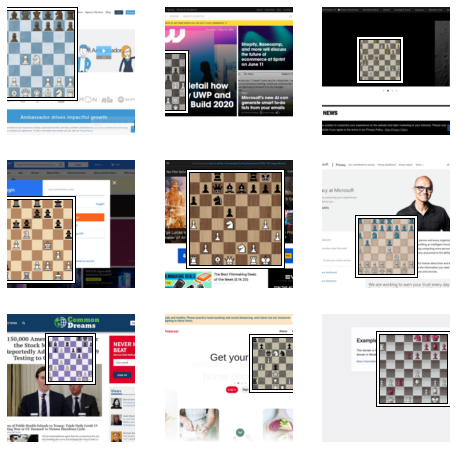

In [ ]:
dls.show_batch(max_n=9, figsize=(8, 8))

In [ ]:
learn = cnn_learner(dls, resnet18, 
                    metrics=[iou], 
                    loss_func=MSELossFlat())
learn.model.cuda();

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
%debug

> /Users/id/nbs/venv/lib/python3.7/site-packages/torch/cuda/__init__.py(164)_lazy_init()
    162                 "multiprocessing, you must use the 'spawn' start method")
    163         if not hasattr(torch._C, '_cuda_getDeviceCount'):
--> 164             raise AssertionError("Torch not compiled with CUDA enabled")
    165         if _cudart is None:
    166             raise AssertionError(



ipdb>  u


> /Users/id/nbs/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(491)<lambda>()
    489             Module: self
    490         """
--> 491         return self._apply(lambda t: t.cuda(device))
    492 
    493     def xpu(self: T, device: Optional[Union[int, device]] = None) -> T:



ipdb>  q



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



In [ ]:
d


In [ ]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,iou,time
0,4.101954,1.863479,0.020064,00:02


epoch,train_loss,valid_loss,iou,time
0,3.577185,1.814246,0.027965,00:02
1,4.007805,1.713767,0.034635,00:02
2,3.822658,1.492343,0.047794,00:02
3,3.774136,1.424591,0.050156,00:02
4,3.757502,1.413293,0.058228,00:02
5,3.683643,1.377962,0.051977,00:02
6,3.616832,1.290937,0.055055,00:02
7,3.529407,1.231704,0.049979,00:02
8,3.491573,1.225529,0.040197,00:02
9,3.492786,1.214628,0.041716,00:02


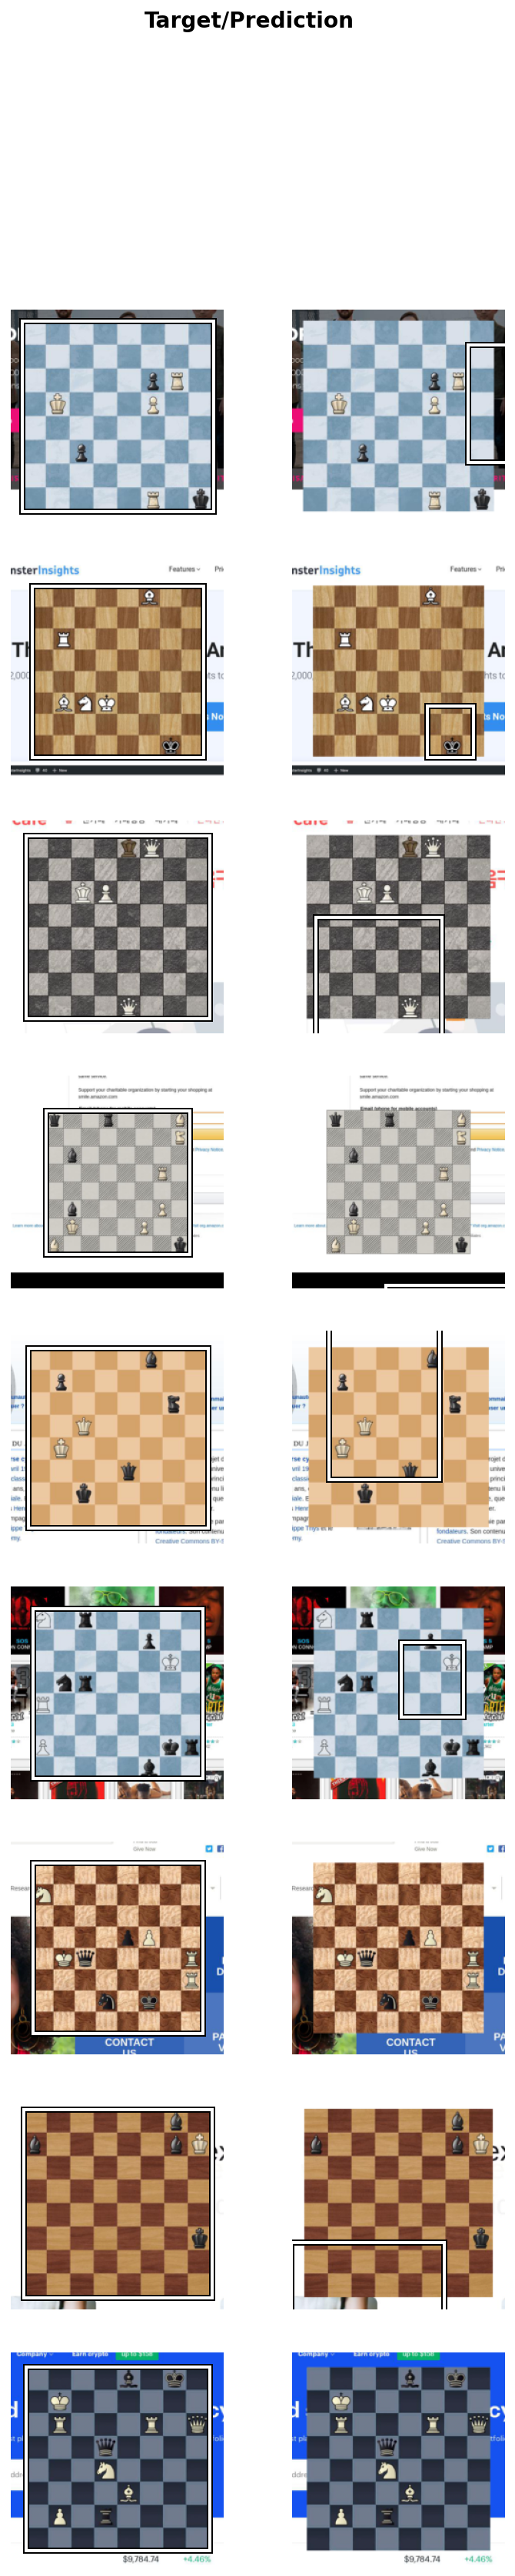

In [ ]:
learn.show_results()

In [ ]:
learn.save("mymodel.pth")

Path('models/mymodel.pth.pth')

In [ ]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                      